# Import

In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

ROOT_PATH = 'gamma'

In [2]:
def line_plot(y_test, y_pred, plot_value, value, plot_name=None):

    plot_data = [('white', 'red', '#4682B4', ''), ('white', 'black', 'gray', '_colored')]
    for color, marker_color, line_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинное значение', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Оцененное значение', color=line_color)  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(test_intervals_Y[:plot_value, value])))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=1) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")


def scatter_plot(y_test, y_pred, lim_value, plot_name=None):
    plot_data = [(None, ''), ('grey', '_colored')]  # Store plot parameters
    for color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create new figure for each plot
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color=color)  # Use color directly
        sns.lineplot(x=[0, lim_value], y=[0, lim_value], color='black')
        plt.xlim(0, lim_value)
        plt.ylim(0, lim_value)
        plt.xlabel('Истинные значения', fontsize=12)
        plt.ylabel('Предсказанные значения', fontsize=12)
        plt.grid(alpha=0.5, color='black')

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

def reccur_potok(alpha, beta):
    return random.gammavariate(alpha, beta)


def gen_recurr(row, col, y_pred1, y_pred2):
    time_list = np.zeros((row, col)) # Use numpy array directly
    alpha_list = y_pred1 # Vectorized alpha and beta extraction
    beta_list = y_pred2

    for i in range(row):
        time = 0
        for j in range(col):
            time += reccur_potok(abs(alpha_list[i]), abs(beta_list[i])) # Use pre-calculated alpha and beta
            time_list[i, j] = time # Use numpy indexing

    df_prov = pd.DataFrame(time_list)
    return df_prov

def print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list):
    relative_error_mean_list = []
    relative_error_std_list = []
    for i in range(X_test_interval.shape[0]):
        relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
        relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

    abs_list = []
    abs_itog_list = itog_itog_list
    for i in range(X_test_interval.shape[0]):
        for j in range(X_test_interval.shape[1]):
            abs_itog_list[i][j] = abs(itog_itog_list[i][j])
        abs_list.append(max(itog_itog_list[i]))

    metrics_df = pd.DataFrame({
        'relative_error_mean': relative_error_mean_list,
        'relative_error_std': relative_error_std_list,
        'abs_list': abs_list
    })
    
    test_result_mean = {
        'relative_error_mean_mean': metrics_df['relative_error_mean'].mean(),
        'relative_error_mean_median': metrics_df['relative_error_mean'].median(),
        'relative_error_std_mean': metrics_df['relative_error_std'].mean(),
        'relative_error_std_median': metrics_df['relative_error_std'].median(),
        'abs_mean': metrics_df['abs_list'].mean(),
        'abs_median': metrics_df['abs_list'].median()
    }

    metrics_mean_df = pd.DataFrame([test_result_mean])

    for key, value in test_result_mean.items():
        print(f'{key}:\t{value:.3f}')
        
    return 


def evaluate_regression(y_true, y_pred, param_name):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{param_name}")
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R² Score: {r2:.3f}')
    return # No need to explicitly return None

def get_intervals_from_df(df):
    intervals = df.diff(axis=1).iloc[:, 1:]
    intervals.columns = range(intervals.shape[1])
    return intervals

def calculate_statistics(X):
    n_observations = X.shape[0]
    stat_M = np.zeros((n_observations, 10))

    # Векторизованные вычисления для основных статистик
    stat_M[:, 0] = np.mean(X, axis=1)
    stat_M[:, 1] = np.var(X, axis=1)
    stat_M[:, 2] = np.std(X, axis=1)
    stat_M[:, 3] = stat_M[:, 2] / stat_M[:, 0]  # Коэффициент вариации

    # Квантили. Избегаем повторного вычисления квантилей
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
    quantiles_values = np.quantile(X, quantiles, axis=1)
    stat_M[:, 4:10] = quantiles_values.T # Транспонируем, чтобы правильно разместить

    return stat_M

# Read and split

In [3]:
df = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/gamma.csv", sep=",", index_col=0)

In [4]:
df.shape

(10000, 10003)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,alpha_value,beta_value,lmbd
0,9.343583,24.050263,40.751480,50.209360,58.664292,78.596712,102.518527,111.466802,114.376423,116.995200,137.686893,159.228045,178.798282,219.273808,229.349809,248.393271,258.342649,268.207497,282.151013,299.288922,332.739063,375.007074,378.596550,405.275772,416.261764,428.702395,450.058899,475.772038,497.780316,526.072149,558.236553,571.203034,592.910297,653.228458,674.465629,699.195855,718.457322,726.819310,732.716578,743.204772,...,179733.268786,179744.100627,179744.796933,179776.501433,179798.019448,179810.054280,179813.301039,179841.222576,179850.583361,179865.061346,179873.008332,179888.638140,179912.017539,179924.672917,179934.652648,179947.745309,179972.256598,179986.187639,180003.185533,180031.622912,180045.404662,180055.897876,180079.456020,180098.824549,180105.095287,180118.622355,180135.675659,180150.040009,180163.371400,180177.631618,180203.198989,180230.027160,180251.512060,180263.837382,180266.971842,180270.499049,180289.914301,2.556922,7.084587,0.055204
1,13.113272,27.449518,34.220554,51.454846,66.901731,85.119949,102.681232,142.213377,156.491405,172.231863,191.470871,215.146707,221.494150,243.784881,263.641251,289.903893,306.363237,309.417910,328.965861,338.630020,398.524977,439.104216,468.785505,495.172405,503.276265,518.445356,537.269462,554.204628,582.400362,596.586167,630.033535,663.263113,672.372728,682.747536,698.773967,708.656603,711.690550,735.833376,755.525746,762.132848,...,194847.304084,194873.188006,194895.229175,194922.980322,194941.936176,194964.607869,194974.861922,194982.213444,195027.081045,195047.293485,195059.450544,195065.626026,195096.654171,195099.789507,195121.265432,195122.472123,195162.075981,195206.471439,195216.674833,195234.553232,195243.837427,195261.413306,195276.284380,195309.340104,195311.344527,195315.198430,195330.187395,195348.344125,195356.121060,195386.135375,195398.397480,195409.221121,195436.454127,195453.576784,195459.827769,195466.936433,195500.488462,2.693336,7.253865,0.051185
2,2.385455,5.106320,5.897963,8.942784,10.605911,11.783556,14.556654,16.313359,18.469281,18.999472,20.173759,22.048332,27.208705,28.273960,31.532176,32.798476,32.961642,34.168048,37.758982,39.819199,41.963861,43.470500,45.163109,47.008312,47.298390,48.411485,54.226581,57.212859,59.478359,61.329298,63.010568,64.756059,67.686832,69.821822,71.483909,73.516404,76.334770,77.969292,80.635432,82.645428,...,20173.474461,20177.639558,20180.514015,20181.137436,20182.220740,20183.292951,20186.145059,20188.625722,20189.736456,20193.167445,20197.193921,20197.958624,20199.226163,20201.608146,20202.379244,20203.810825,20205.703990,20207.819624,20208.698651,20209.536396,20212.699694,20213.906158,20216.214597,20219.891075,20222.642413,20224.562332,20224.794771,20225.884235,20228.049064,20229.215342,20231.936898,20232.919761,20235.276254,20237.080308,20239.662622,20241.284233,20243.500719,2.785722,0.727824,0.493215
3,4.953679,14.490374,25.508710,26.831450,52.338377,66.996525,71.259731,101.641627,103.966712,106.742551,108.036573,129.540427,134.797162,181.554336,194.471530,225.116340,249.961123,256.622765,267.324670,279.202437,289.875524,297.004133,317.693798,334.414813,340.913778,353.812440,398.186093,411.620948,425.741722,443.844522,473.904415,479.477832,499.363964,510.575280,537.459665,550.597861,552.417114,556.334280,565.083013,569.568590,...,121684.918082,121692.735190,121704.002982,121710.495283,121724.465043,121775.383804,121782.396502,121789.940675,121792.185898,121820.528902,121830.884855,121863.668775,121879.152664,121886.292780,121893.606416,121908.950913,121968.913095,122000.053941,122012.286915,122021.416362,122023.761687,122025.244947,122042.260530,122069.074750,122083.975599,12209

In [6]:
intervals_df = get_intervals_from_df(df.iloc[0:10000, :10000])
intervals_df['alpha_value'] = df['alpha_value']
intervals_df['beta_value'] = df['beta_value']
intervals_df['lmbd'] = df['lmbd']

In [11]:
intervals_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,alpha_value,beta_value,lmbd
0,14.706680,16.701217,9.457879,8.454932,19.932421,23.921815,8.948274,2.909621,2.618777,20.691693,21.541152,19.570238,40.475526,10.076001,19.043463,9.949378,9.864848,13.943517,17.137908,33.450141,42.268011,3.589476,26.679222,10.985992,12.440631,21.356504,25.713140,22.008278,28.291833,32.164404,12.966481,21.707263,60.318161,21.237171,24.730227,19.261467,8.361988,5.897268,10.488194,13.510972,...,4.599580,10.831841,0.696306,31.704499,21.518016,12.034831,3.246760,27.921536,9.360785,14.477985,7.946986,15.629808,23.379400,12.655377,9.979731,13.092660,24.511289,13.931041,16.997894,28.437379,13.781749,10.493214,23.558144,19.368530,6.270738,13.527067,17.053304,14.364350,13.331392,14.260217,25.567371,26.828172,21.484900,12.325321,3.134461,3.527206,19.415252,2.556922,7.084587,0.055204
1,14.336246,6.771037,17.234292,15.446884,18.218218,17.561283,39.532145,14.278028,15.740458,19.239008,23.675837,6.347443,22.290731,19.856370,26.262642,16.459345,3.054672,19.547951,9.664159,59.894957,40.579238,29.681289,26.386900,8.103860,15.169092,18.824105,16.935166,28.195734,14.185805,33.447367,33.229579,9.109614,10.374808,16.026432,9.882635,3.033947,24.142826,19.692370,6.607102,4.802065,...,28.136195,25.883922,22.041169,27.751147,18.955855,22.671692,10.254054,7.351522,44.867600,20.212440,12.157059,6.175482,31.028145,3.135336,21.475925,1.206691,39.603858,44.395458,10.203394,17.878398,9.284195,17.575879,14.871074,33.055724,2.004423,3.853902,14.988965,18.156731,7.776935,30.014315,12.262105,10.823641,27.233006,17.122657,6.250985,7.108664,33.552029,2.693336,7.253865,0.051185
2,2.720865,0.791643,3.044820,1.663127,1.177645,2.773098,1.756705,2.155922,0.530192,1.174286,1.874573,5.160373,1.065255,3.258215,1.266301,0.163165,1.206406,3.590933,2.060217,2.144662,1.506639,1.692609,1.845203,0.290078,1.113096,5.815096,2.986278,2.265500,1.850939,1.681270,1.745491,2.930773,2.134990,1.662087,2.032495,2.818366,1.634522,2.666140,2.009996,0.799878,...,1.595220,4.165098,2.874457,0.623421,1.083304,1.072211,2.852108,2.480664,1.110734,3.430989,4.026476,0.764703,1.267540,2.381983,0.771097,1.431581,1.893165,2.115634,0.879027,0.837745,3.163298,1.206464,2.308438,3.676479,2.751337,1.919919,0.232439,1.089464,2.164829,1.166278,2.721556,0.982862,2.356493,1.804054,2.582314,1.621612,2.216486,2.785722,0.727824,0.493215
3,9.536695,11.018335,1.322741,25.506927,14.658147,4.263206,30.381897,2.325084,2.775839,1.294022,21.503854,5.256735,46.757174,12.917193,30.644810,24.844783,6.661642,10.701905,11.877767,10.673087,7.128609,20.689665,16.721015,6.498966,12.898661,44.373653,13.434855,14.120774,18.102800,30.059893,5.573417,19.886132,11.211316,26.884386,13.138195,1.819254,3.917166,8.748733,4.485577,10.319586,...,2.239747,7.817108,11.267791,6.492301,13.969760,50.918761,7.012698,7.544173,2.245223,28.343004,10.355953,32.783920,15.483888,7.140116,7.313636,15.344498,59.962182,31.140845,12.232974,9.129447,2.345324,1.483261,17.015582,26.814220,14.900850,9.579786,7.826173,8.241361,8.586827,4.994041,9.726177,16.169548,5.512945,15.897650,20.602869,6.813201,59.975697,1.378063,8.950797,0.081072
4,8.491212,14.075186,4.250582,3.428300,15.586115,30.871473,47.125944,2.409645,15.853447,26.279272,9.604289,6.724654,40.171361,5.725232,5.209543,3.634831,10.183662,21.144112,0.541971,27.562226,11.820344,13.408274,13.229080,4.101702,0.395055,2.366608,10.580113,17.589886,10.063632,54.217567,2.643731,5.041903,11.046689,8.364147,14.119810,2.786861,49.715919,2.498096,1.580628,10.683131,...,43.113429,1.350420,34.529101,7.913716,5.995088,1.350515,1.054465,6.909927,11.122004,16.791836,19.272417,18.546344,8.435285,10.434518,5.546968,3.685984,10.326406,7.202074,30.291841,9.007124,3.683030,8.112566,4.284532,10.2316

In [22]:
train_intervals_df, test_intervals_df = train_test_split(intervals_df, train_size=0.8, random_state=SEED, shuffle=True)

In [23]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [24]:
train_intervals_X = np.array(train_intervals_df)[:, :9999]
train_intervals_Y = np.array(train_intervals_df)[:, 9999:]
test_intervals_X = np.array(test_intervals_df)[:, :9999]
test_intervals_Y = np.array(test_intervals_df)[:, 9999:]
val_intervals_X = np.array(val_intervals_df)[:, :9999]
val_intervals_Y = np.array(val_intervals_df)[:, 9999:]

# Метод моментов

In [26]:
mean_emp = test_intervals_X.mean(axis=1)

In [27]:
var_emp = test_intervals_X.var(axis=1)

In [28]:
alpha = mean_emp ** 2 / var_emp
beta = var_emp / mean_emp
lmbd = 1 / (beta * alpha)

In [31]:
evaluate_regression(test_intervals_Y[:, 0], alpha, "value1")
evaluate_regression(test_intervals_Y[:, 1], beta, "value2")
evaluate_regression(test_intervals_Y[:, 2], lmbd, "value3")


value1
MAE: 0.035
MSE: 0.002
RMSE: 0.047
MAPE: 1.362%
R² Score: 0.999

value2
MAE: 0.073
MSE: 0.011
RMSE: 0.107
MAPE: 1.436%
R² Score: 0.999

value3
MAE: 0.002
MSE: 0.000
RMSE: 0.006
MAPE: 0.543%
R² Score: 1.000


# Catboost

## Catboost интервалы

In [8]:
# %pip install catboost

In [21]:
from catboost import CatBoostRegressor

SEED = 42

In [14]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

inter = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
inter.fit(train_intervals_X, train_intervals_Y, eval_set=(val_intervals_X, val_intervals_Y), use_best_model=True)

0:	learn: 3.1319016	test: 3.2023086	best: 3.2023086 (0)	total: 631ms	remaining: 21m
100:	learn: 1.8112504	test: 2.0012888	best: 2.0012888 (100)	total: 43.4s	remaining: 13m 35s
200:	learn: 1.4769390	test: 1.7317406	best: 1.7317406 (200)	total: 1m 23s	remaining: 12m 30s
300:	learn: 1.2467239	test: 1.5478020	best: 1.5478020 (300)	total: 2m 4s	remaining: 11m 42s
400:	learn: 1.0590281	test: 1.4112168	best: 1.4112168 (400)	total: 2m 44s	remaining: 10m 57s
500:	learn: 0.9151807	test: 1.3161166	best: 1.3161166 (500)	total: 3m 25s	remaining: 10m 14s
600:	learn: 0.8078948	test: 1.2393703	best: 1.2393703 (600)	total: 4m 5s	remaining: 9m 31s
700:	learn: 0.7257103	test: 1.1839761	best: 1.1839761 (700)	total: 4m 45s	remaining: 8m 49s
800:	learn: 0.6589823	test: 1.1393375	best: 1.1393375 (800)	total: 5m 26s	remaining: 8m 8s
900:	learn: 0.6045336	test: 1.1040479	best: 1.1040479 (900)	total: 6m 6s	remaining: 7m 26s
1000:	learn: 0.5596101	test: 1.0728611	best: 1.0728611 (1000)	total: 6m 46s	remaining: 6

In [15]:
pred = inter.predict(test_intervals_X)

In [26]:
inter.save_model(ROOT_PATH + "_inter")

In [16]:
# inter = CatBoostRegressor() 
# inter.load_model('/home/jupyter/datasphere/project/recurr_gamma')
# pred = inter.predict(test_intervals_X)

### Метрики

In [16]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.360
MSE: 0.198
RMSE: 0.445
MAPE: 17.047%
R² Score: 0.890

value2
MAE: 0.558
MSE: 0.591
RMSE: 0.769
MAPE: 12.208%
R² Score: 0.929

value3
MAE: 0.040
MSE: 0.022
RMSE: 0.148
MAPE: 12.579%
R² Score: 0.945


In [17]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [18]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [19]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	0.171
relative_error_mean_median:	0.100
relative_error_std_mean:	0.132
relative_error_std_median:	0.099
abs_mean:	1405.122
abs_median:	936.000


### Рисунки

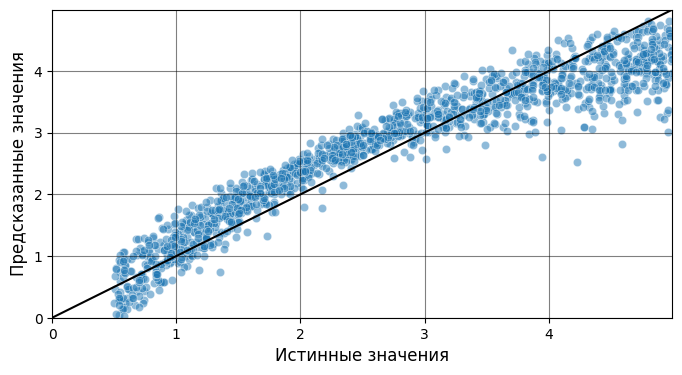

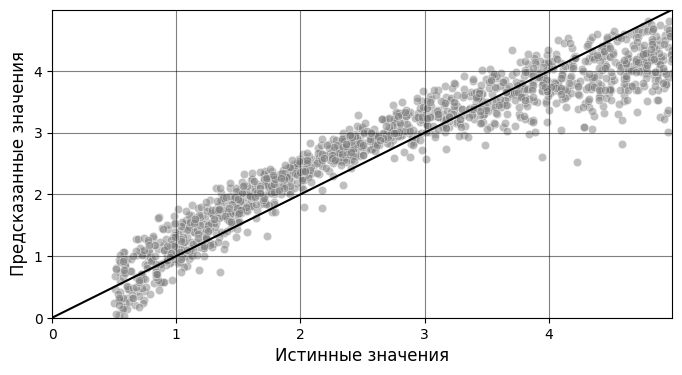

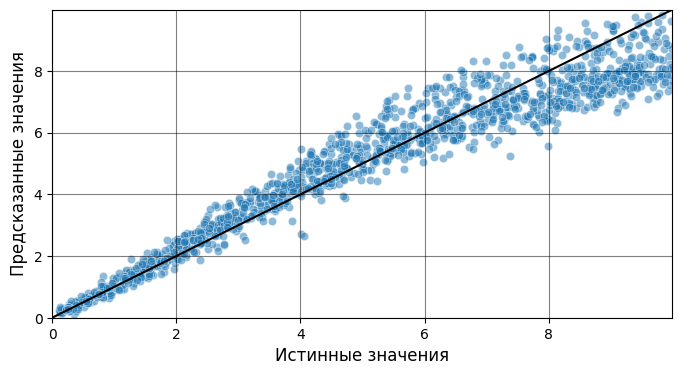

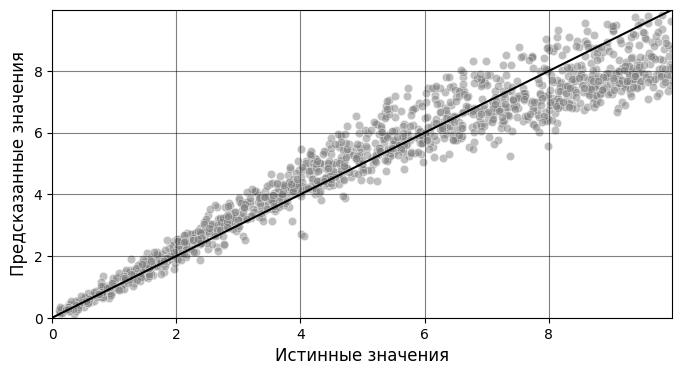

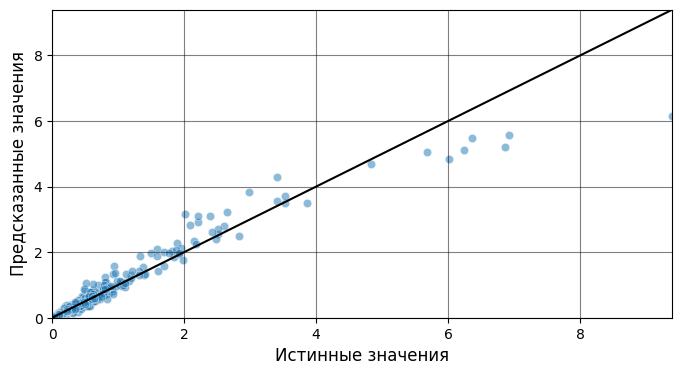

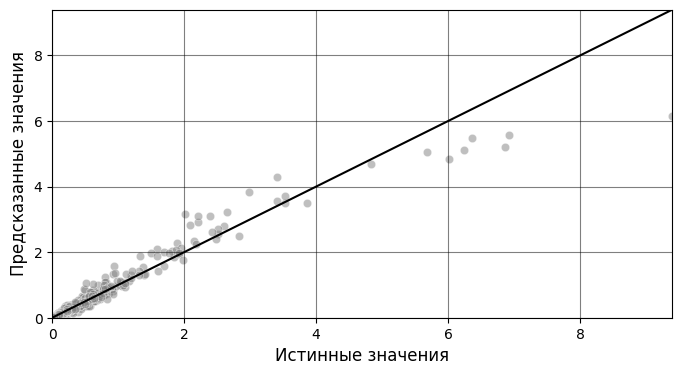

In [21]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1_inter")
scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2_inter")
scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,2]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3_inter")

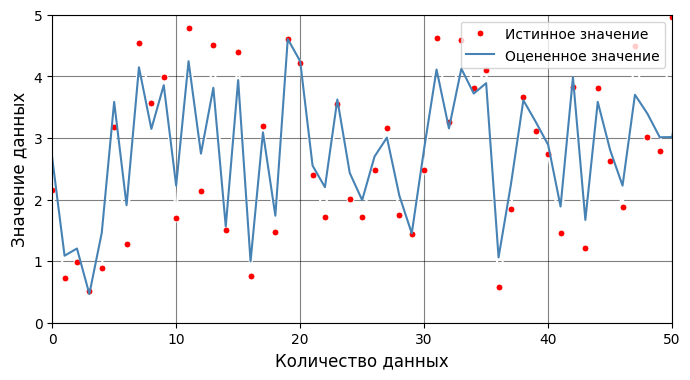

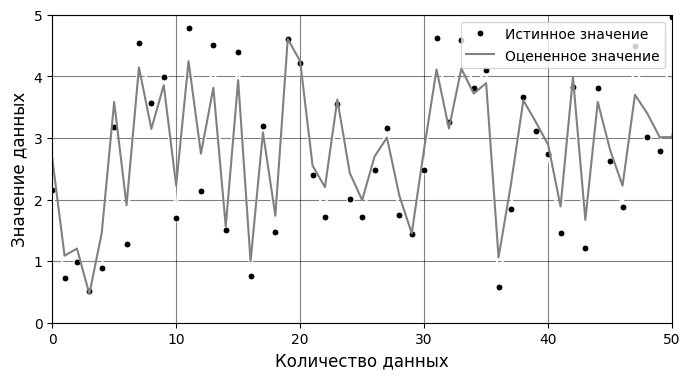

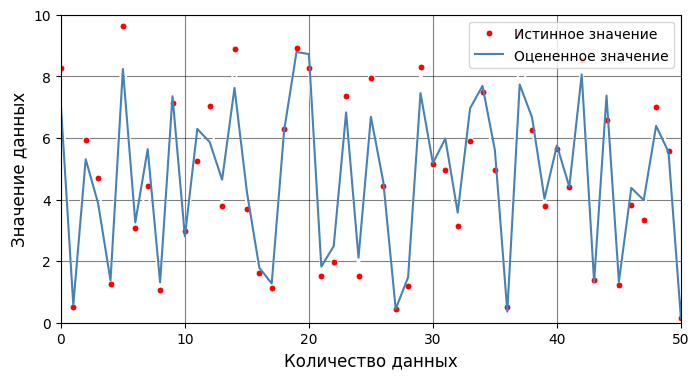

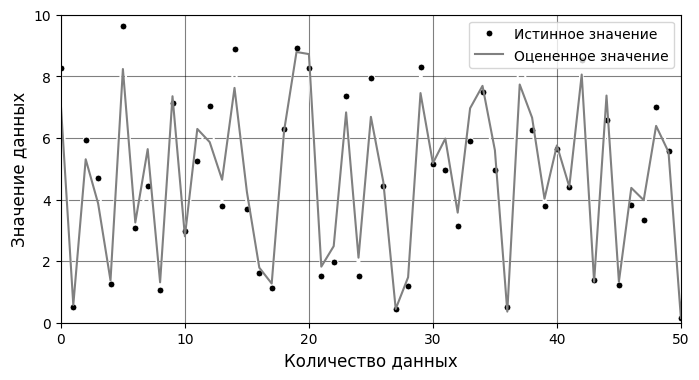

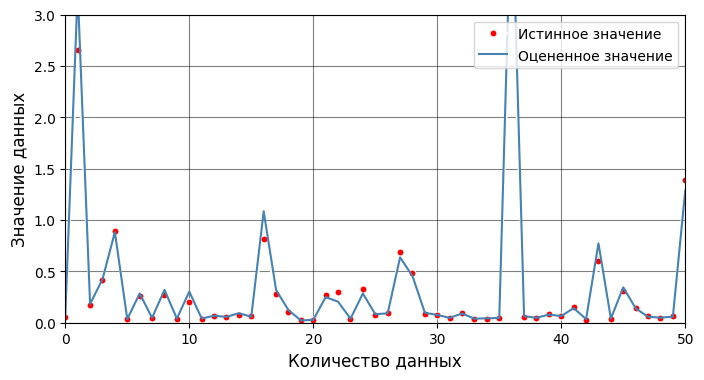

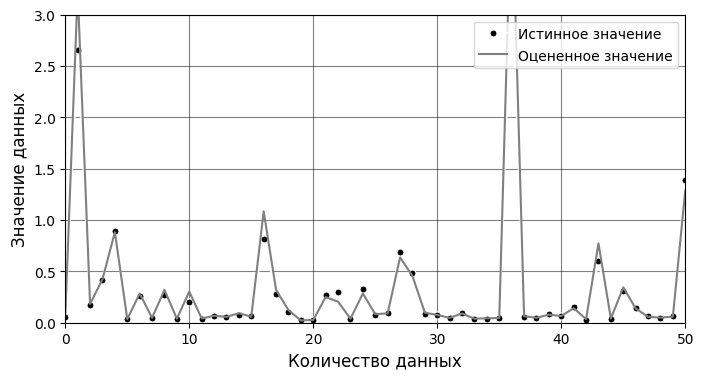

In [22]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1_inter_line")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2_inter_line")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3_inter_line")

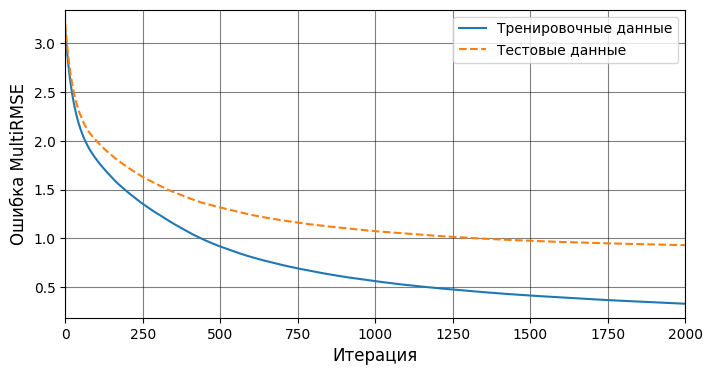

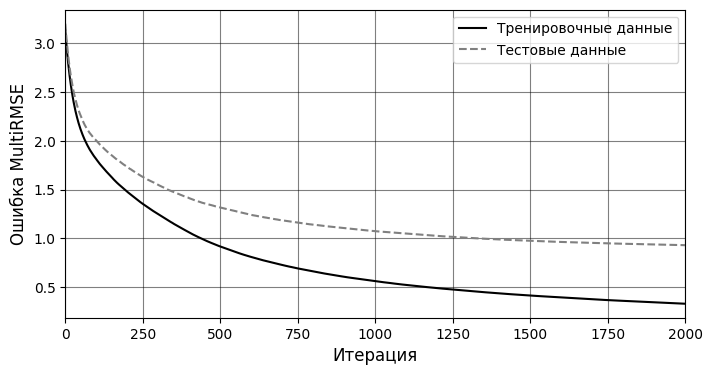

In [25]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/test_error.tsv', sep='\t', index_col=0)

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train_inter_colored.pdf', bbox_inches="tight")

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train_inter.pdf', bbox_inches="tight")

## Catboost статистика

In [27]:
train_stat_M = calculate_statistics(train_intervals_X)
test_stat_M = calculate_statistics(test_intervals_X)
val_stat_M = calculate_statistics(val_intervals_X)

In [28]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 500,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 100,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.003
}

stat = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
stat.fit(train_stat_M, train_intervals_Y, eval_set=(val_stat_M, val_intervals_Y), use_best_model=True)

0:	learn: 3.0932765	test: 3.1632243	best: 3.1632243 (0)	total: 3.59ms	remaining: 7.18s
500:	learn: 0.1499110	test: 0.2499603	best: 0.2499603 (500)	total: 1.14s	remaining: 3.4s
1000:	learn: 0.1347927	test: 0.2131205	best: 0.2131205 (1000)	total: 2.29s	remaining: 2.28s
1500:	learn: 0.1295204	test: 0.2041230	best: 0.2041174 (1497)	total: 3.42s	remaining: 1.14s
1999:	learn: 0.1260151	test: 0.2006398	best: 0.2006398 (1999)	total: 4.56s	remaining: 0us

bestTest = 0.2006397682
bestIteration = 1999



In [29]:
pred = stat.predict(test_stat_M)

In [30]:
stat.save_model(ROOT_PATH + "_stat")

In [27]:
# stat = CatBoostRegressor() 
# stat.load_model('/home/jupyter/datasphere/project/recurr_gamma')
# pred = stat.predict(test_intervals_X)

### Метрики

In [31]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.037
MSE: 0.002
RMSE: 0.048
MAPE: 1.451%
R² Score: 0.999

value2
MAE: 0.080
MSE: 0.012
RMSE: 0.110
MAPE: 2.124%
R² Score: 0.999

value3
MAE: 0.014
MSE: 0.025
RMSE: 0.159
MAPE: 2.078%
R² Score: 0.937


In [32]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [33]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [34]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	0.016
relative_error_mean_median:	0.009
relative_error_std_mean:	0.018
relative_error_std_median:	0.012
abs_mean:	194.586
abs_median:	134.000


### Рисунки

In [35]:
model_path = '_stat'

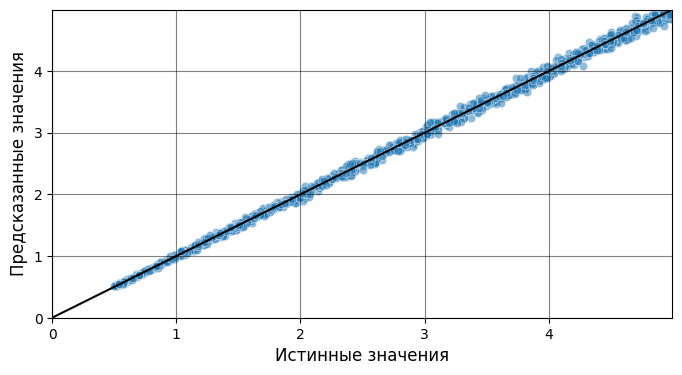

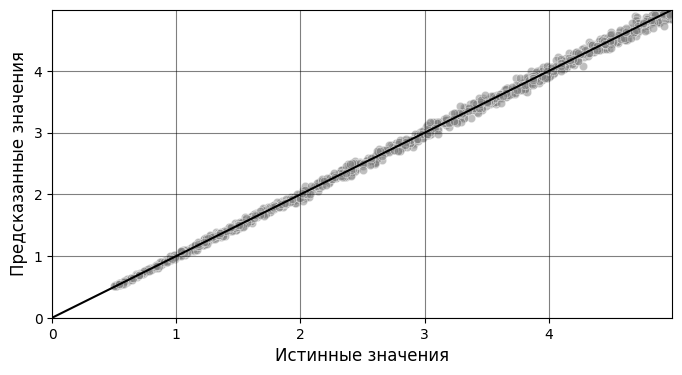

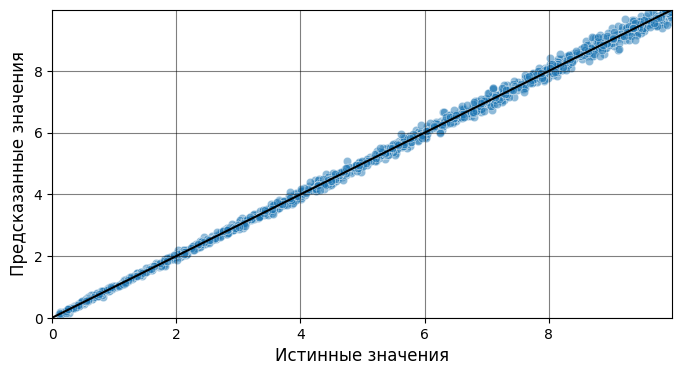

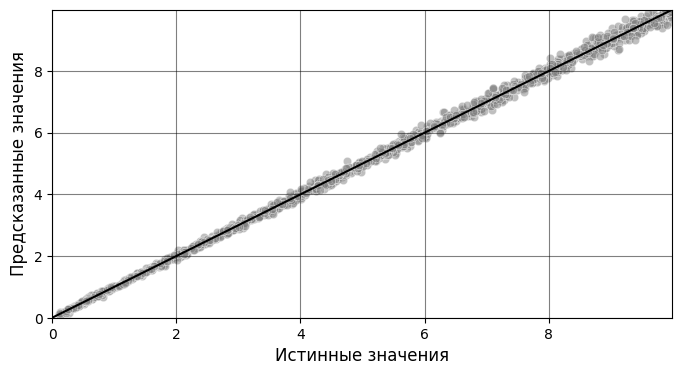

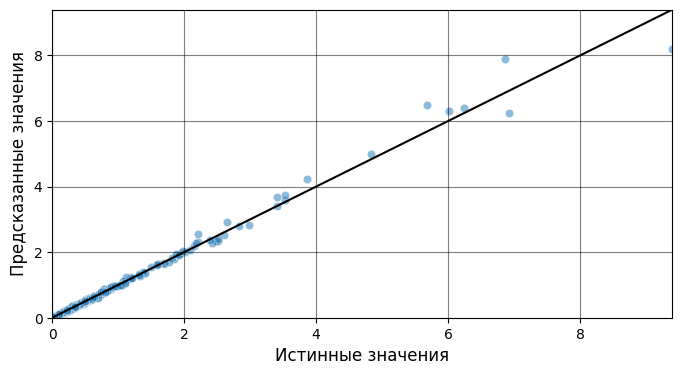

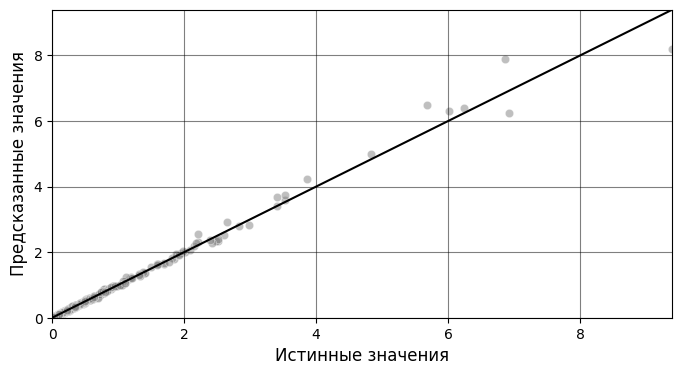

In [36]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path)
scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path)
scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,2]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path)

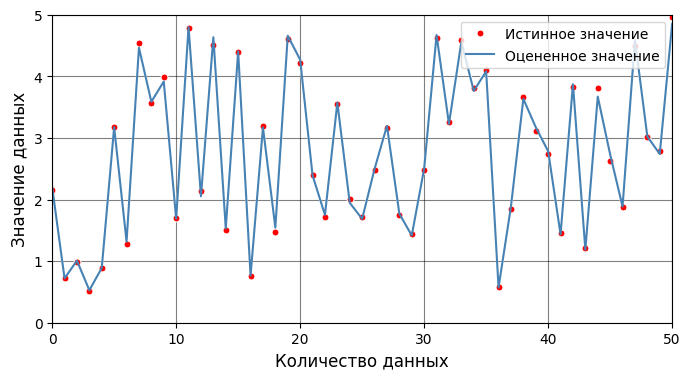

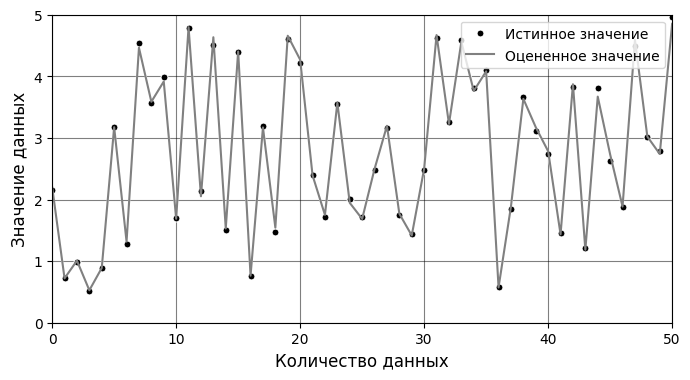

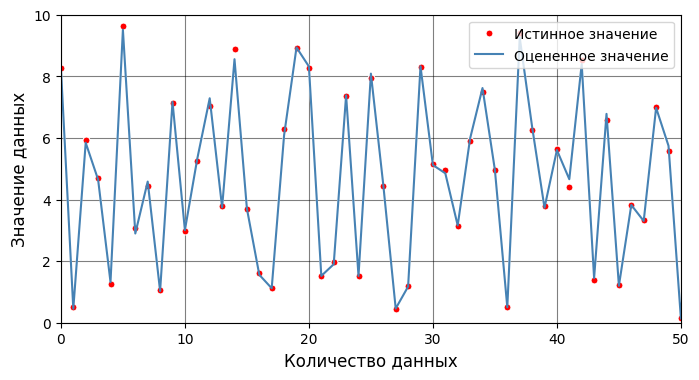

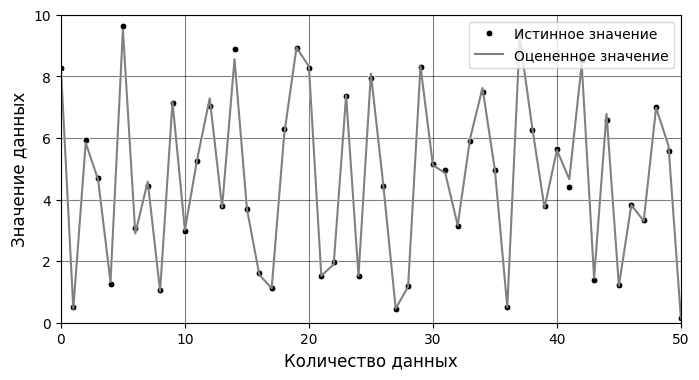

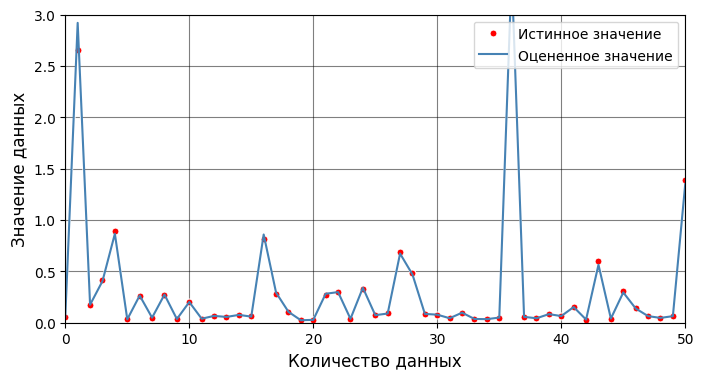

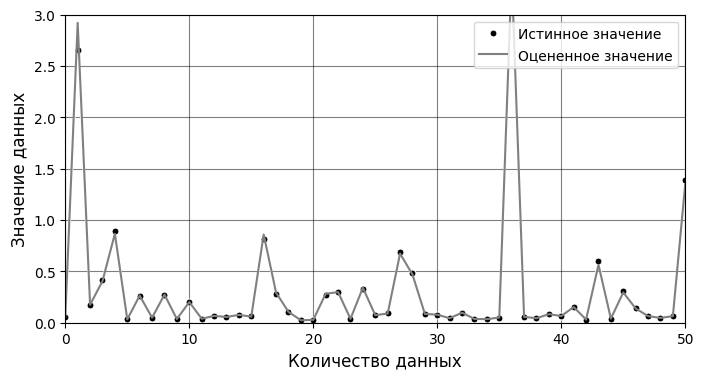

In [37]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path + "_line")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path + "_line")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path + "_line")

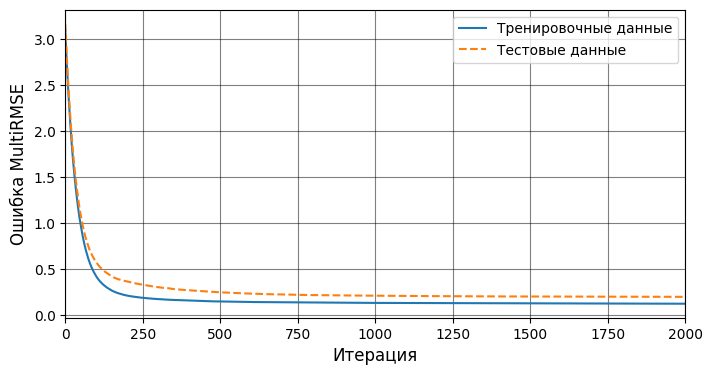

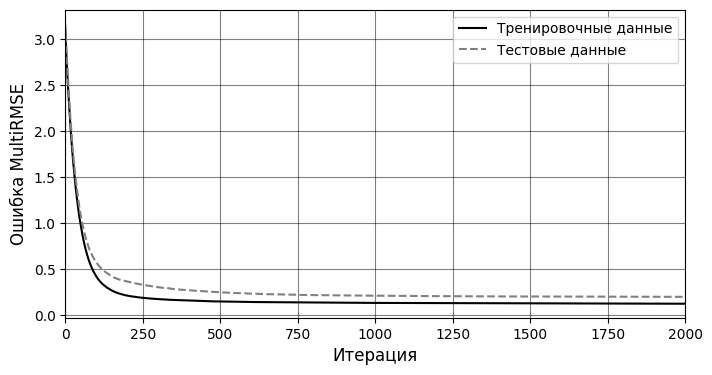

In [39]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/test_error.tsv', sep='\t', index_col=0)

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '_colored.pdf', bbox_inches="tight")

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '.pdf', bbox_inches="tight")

## Catboost моменты

In [56]:
train_df, test_df = train_test_split(df.iloc[:, :10003], train_size=0.8, random_state=SEED, shuffle=True)

In [57]:
test_df, val_df = train_test_split(df.iloc[:, :10003], train_size=0.7, random_state=SEED, shuffle=True)

In [58]:
train_X = np.array(train_df)[:, :10000]
train_Y = np.array(train_df)[:, 10000:]
test_X = np.array(test_df)[:, :10000]
test_Y = np.array(test_df)[:, 10000:]
val_X = np.array(val_df)[:, :10000]
val_Y = np.array(val_df)[:, 10000:]

In [62]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

moments = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
moments.fit(train_X, train_Y, eval_set=(val_X, val_Y), use_best_model=True)

0:	learn: 3.1243210	test: 3.1851702	best: 3.1851702 (0)	total: 623ms	remaining: 20m 45s
100:	learn: 2.0377094	test: 2.0536414	best: 2.0536414 (100)	total: 41s	remaining: 12m 50s
200:	learn: 1.9519515	test: 1.9811377	best: 1.9811377 (200)	total: 1m 21s	remaining: 12m 10s
300:	learn: 1.8938105	test: 1.9412321	best: 1.9412321 (300)	total: 2m 2s	remaining: 11m 31s
400:	learn: 1.8200351	test: 1.8932539	best: 1.8932539 (400)	total: 2m 43s	remaining: 10m 51s
500:	learn: 1.7495301	test: 1.8525649	best: 1.8525649 (500)	total: 3m 24s	remaining: 10m 11s
600:	learn: 1.6944487	test: 1.8221678	best: 1.8221678 (600)	total: 4m 5s	remaining: 9m 30s
700:	learn: 1.6450086	test: 1.7967232	best: 1.7967232 (700)	total: 4m 45s	remaining: 8m 49s
800:	learn: 1.5994922	test: 1.7726700	best: 1.7726700 (800)	total: 5m 26s	remaining: 8m 8s
900:	learn: 1.5607956	test: 1.7523665	best: 1.7523665 (900)	total: 6m 7s	remaining: 7m 28s
1000:	learn: 1.5240551	test: 1.7364775	best: 1.7364775 (1000)	total: 6m 48s	remaining:

In [63]:
pred = moments.predict(test_X)

In [64]:
moments.save_model(ROOT_PATH + "_moments")

In [65]:
# moments = CatBoostRegressor() 
# moments.load_model('/home/jupyter/datasphere/project/recurr_gamma')
# pred = moments.predict(test_X)

### Метрики

In [66]:
evaluate_regression(test_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.542
MSE: 0.460
RMSE: 0.678
MAPE: 26.719%
R² Score: 0.725

value2
MAE: 0.832
MSE: 1.071
RMSE: 1.035
MAPE: 24.822%
R² Score: 0.867

value3
MAE: 0.010
MSE: 0.007
RMSE: 0.086
MAPE: 1.821%
R² Score: 0.975


In [67]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [68]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [69]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	3.574
relative_error_mean_median:	0.746
relative_error_std_mean:	2.374
relative_error_std_median:	0.631
abs_mean:	5606.909
abs_median:	5852.500


### Рисунки

In [70]:
model_path = '_moments'

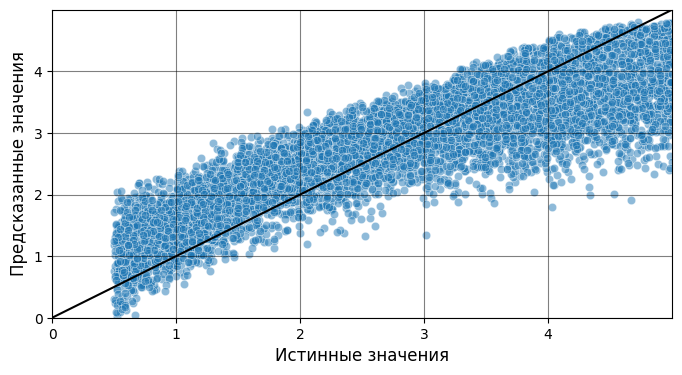

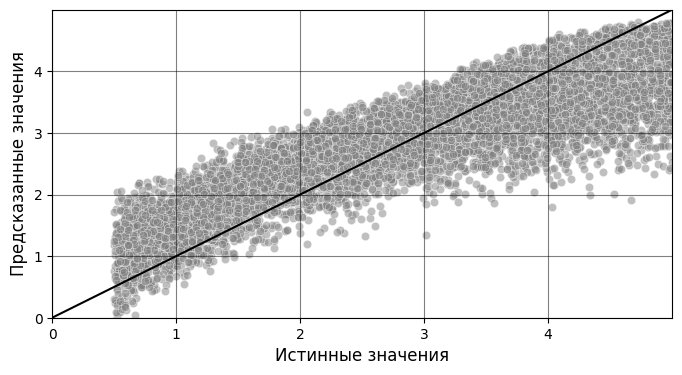

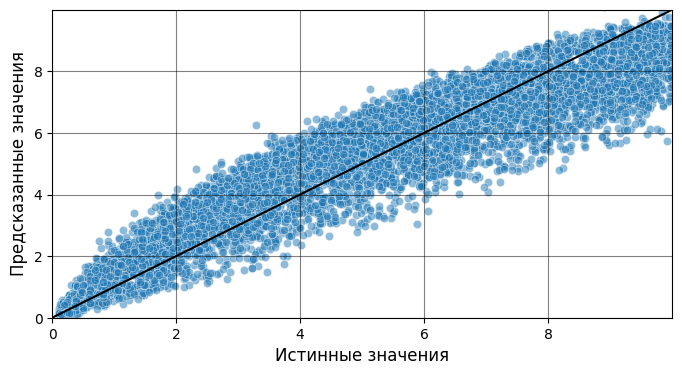

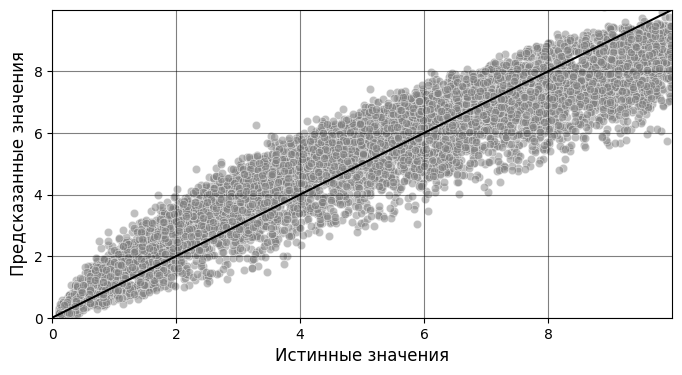

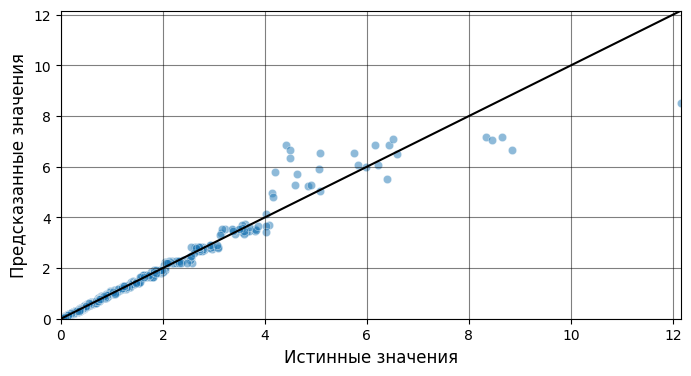

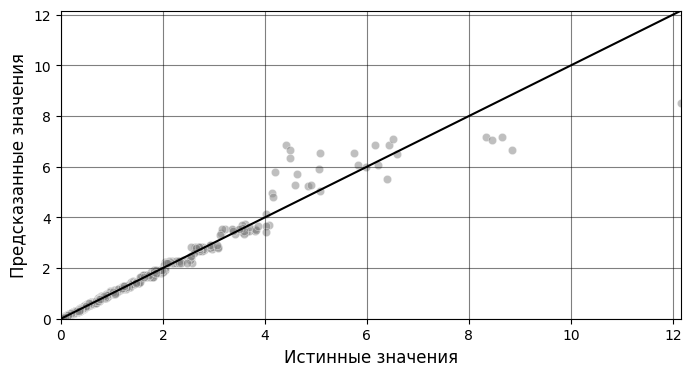

In [74]:
scatter_plot(test_Y[:,0], pred[:,0], max(test_Y[:,0]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path)
scatter_plot(test_Y[:,1], pred[:,1], max(test_Y[:,1]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path)
scatter_plot(test_Y[:,2], pred[:,2], max(test_Y[:,2]), "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path)

In [76]:
def line_plot(y_test, y_pred, plot_value, value, plot_name=None):

    plot_data = [('white', 'red', '#4682B4', ''), ('white', 'black', 'gray', '_colored')]
    for color, marker_color, line_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинное значение', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Оцененное значение', color=line_color)  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(test_Y[:plot_value, value])))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=1) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

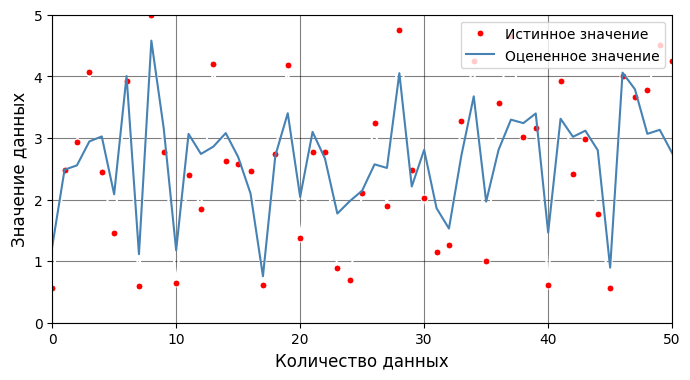

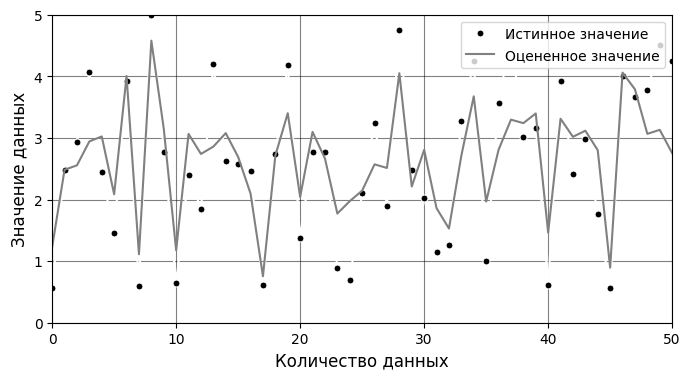

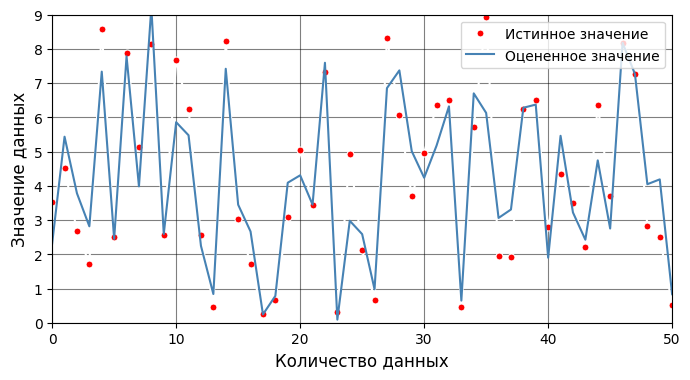

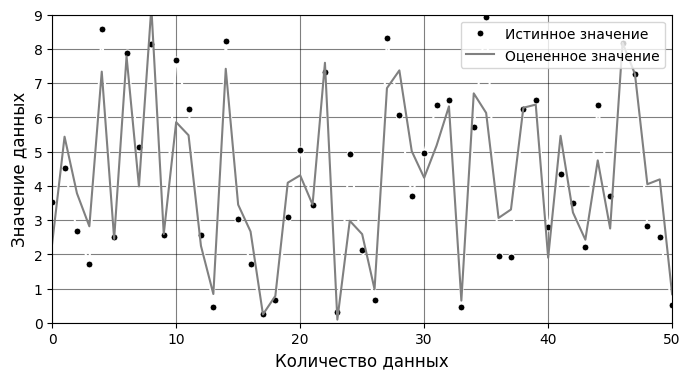

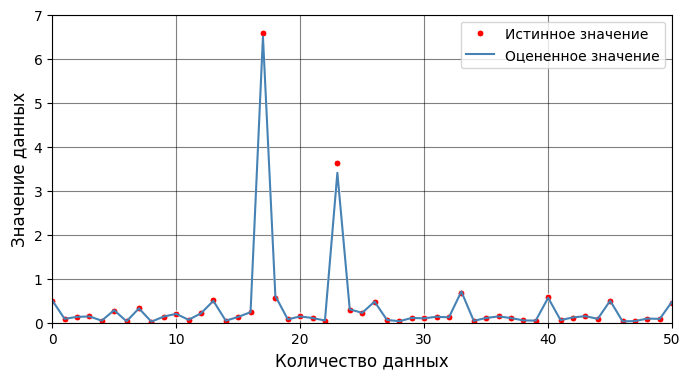

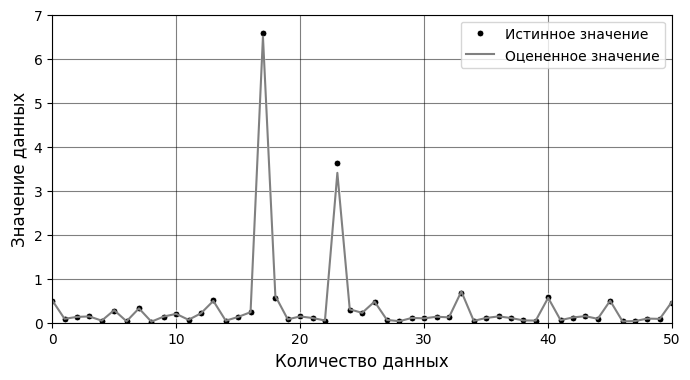

In [77]:
line_plot(test_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val1" + model_path + "_line")
line_plot(test_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val2" + model_path + "_line")
line_plot(test_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/" + ROOT_PATH + "/Untitled Folder/val3" + model_path + "_line")

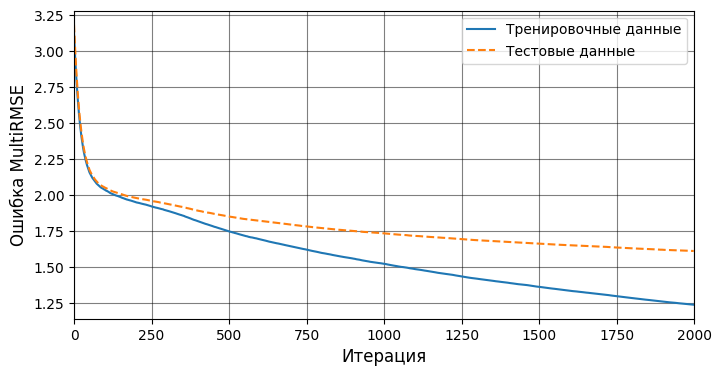

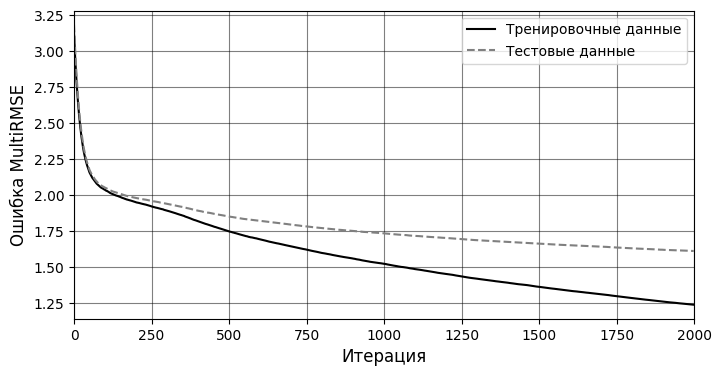

In [78]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/' + ROOT_PATH + '/catboost_info/test_error.tsv', sep='\t', index_col=0)

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '_colored.pdf', bbox_inches="tight")

plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/' + ROOT_PATH + '/Untitled Folder/catboost_train' + model_path + '.pdf', bbox_inches="tight")